# **Capstone project: Providing data-driven suggestions for HR**

## Pace: Plan

### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees. They have the following question: what’s likely to make the employee leave the company?

The goal in this project is to analyze the data collected by the HR department and to build a model that identifies factors that contribute to employees' decision to leave the company.

## Step 1. Imports

### Import packages

In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from xgboost import XGBClassifier, plot_importance
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

### Load dataset
Available in my GitHub repository.

In [48]:
df0 = pd.read_csv("HR_capstone_dataset.csv")


# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Step 2. Data Exploration (Initial EDA and data cleaning)


### Gather basic info and descriptives about the data

In [49]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [50]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


### Rename/standardize columns; check missings, duplicates and outliers

In [51]:
# Display all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [52]:
# force to lower case/standardize them
df0.columns = df0.columns.str.lower()
df0 = df0.rename(columns = {
    "time_spend_company": "tenure",
    "promotion_last_5years": "promotion_5y",
    "average_montly_hours": "avg_Mhours"
})

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project', 'avg_Mhours',
       'tenure', 'work_accident', 'left', 'promotion_5y', 'department',
       'salary'],
      dtype='object')

In [53]:
# Check for missing values
df0.isnull().sum()

satisfaction_level    0
last_evaluation       0
number_project        0
avg_Mhours            0
tenure                0
work_accident         0
left                  0
promotion_5y          0
department            0
salary                0
dtype: int64

In [54]:
# Check for duplicates
df0.duplicated().sum()

np.int64(3008)

In [55]:
df0[df0.duplicated(keep=False)].head(5)

,satisfaction_level,last_evaluation,number_project,avg_Mhours,tenure,work_accident,left,promotion_5y,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [56]:
# Drop duplicates and display the first few rows of a 'new' dataframe
df1 = df0.drop_duplicates()

df1.head()

,satisfaction_level,last_evaluation,number_project,avg_Mhours,tenure,work_accident,left,promotion_5y,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


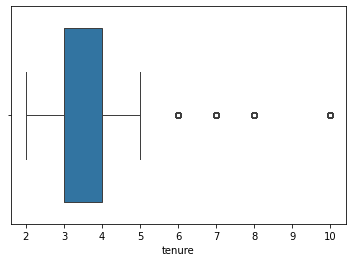

In [57]:
# Check outliers (e.g., through boxplot of tenure)
sns.boxplot(x = "tenure", data=df1)
plt.show()

In [58]:
# Exclude outliers

perc_75 = np.percentile(df1["tenure"], 75)
perc_25 = np.percentile(df1["tenure"], 25)

iqr = perc_75-perc_25

upper_limit = perc_75 + 1.5*iqr
lower_limit = perc_25 - 1.5*iqr

outliers = ((df1["tenure"] > upper_limit) | (df1["tenure"] < lower_limit)).sum()
print("Number of rows containing outliers is", outliers)

Number of rows containing outliers is 824


# Pace: Analyze Stage
- Perform EDA (analyze relationships between variables)



## Data Exploration (Continue EDA)

In [59]:
# Class: get numbers and ^ of people who left vs. stayed
print(df1["left"].value_counts())

df1["left"].value_counts(normalize = True)*100 # good not great, 16.7% of people in the 'left' category 

left
0    10000
1     1991
Name: count, dtype: int64


left
0    83.39588
1    16.60412
Name: proportion, dtype: float64

### Data visualizations

<Axes: xlabel='left', ylabel='satisfaction_level'>

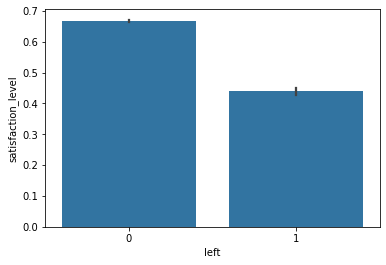

In [60]:
# Visually explore vars

sns.barplot(x = "left", y = "satisfaction_level", data = df1)
#df1.groupby(["left"])["satisfaction_level"].mean()

<Axes: xlabel='avg_Mhours', ylabel='number_project'>

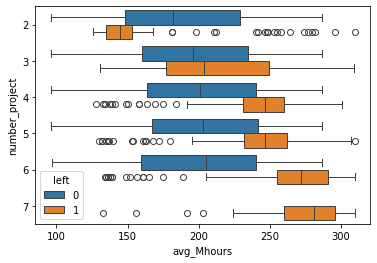

In [61]:
# number_project # avg_Mhours
sns.boxplot(x = "avg_Mhours", y = "number_project", hue = "left", data = df1, orient = "h")

<Axes: xlabel='left', ylabel='promotion_5y'>

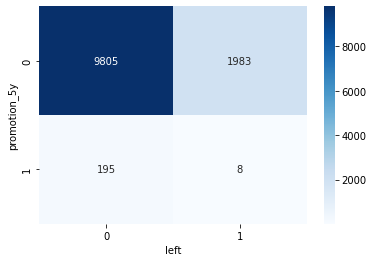

In [62]:
# ct_prop = ct.div(ct.sum(axis=1), axis=0)
# ct_prop.plot(kind="bar", stacked=True)

ct = pd.crosstab(df1["promotion_5y"], df1["left"])
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")

<Axes: xlabel='count', ylabel='department'>

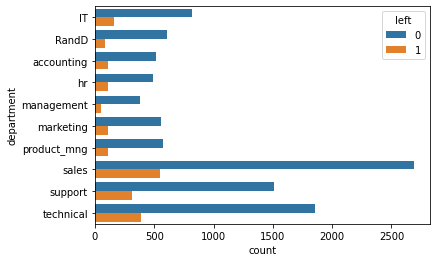

In [63]:
ct0 = df1.groupby(["department", "left"]).size().reset_index(name="count")
sns.barplot(x = "count", y = "department", hue = "left", data = ct0)

<Axes: xlabel='salary', ylabel='count'>

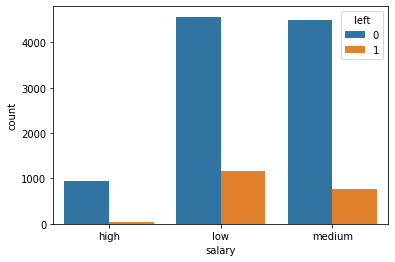

In [64]:
ct = df1.groupby(["salary", "left"]).size().reset_index(name="count")
sns.barplot(data=ct, x="salary", y="count", hue="left")

In [65]:
df1.head()

,satisfaction_level,last_evaluation,number_project,avg_Mhours,tenure,work_accident,left,promotion_5y,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<Axes: >

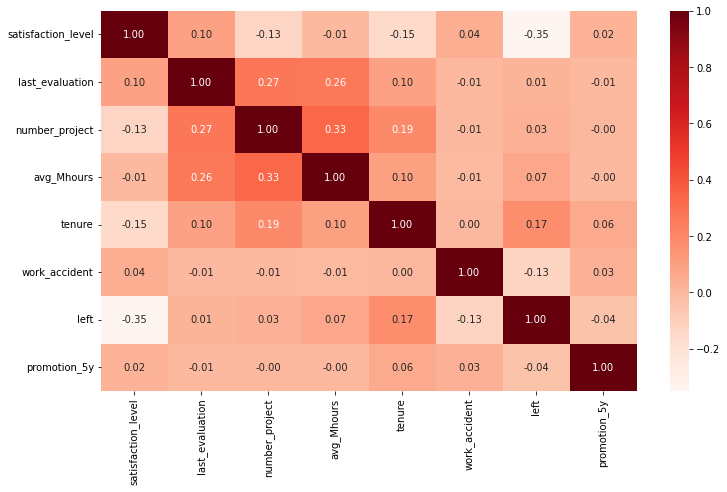

In [68]:
plt.figure(figsize=(12,7))
sns.heatmap(df1.corr(numeric_only=True), annot = True, fmt= ".2f", cmap = "Reds")

### Insights so far:


- More people working on 4 or more projects leave the company than stay. This is especially obvious among people with 6 and 7 projects. In fact, almost all people who used to work on 7 projets left the company.

- People who left the company also reported lower satisfaction. Interestingly, almost none of the people with high salary left the company. 

- Among the smaller number of people who got promoted in last 5 years, almost nobody (only 8 people actually) left the company. So it seems that not-promoted people who work a lot leave the company.

- There do not seem to be patterns between departments with regards to who left and who stayed.

- None of the variables are highly correlated.

# Pace: Construct Stage

This is a binary classification taks. Logistic regression is a natural choice, but also Decision Tree and Gradient Boosting. I proceed with the latter two first because they are more powerful and less demanding regarding assumptions.

## Modeling

### Decision Tree: baseline

In [69]:
### A: Decision Tree

# Class balance checks
df_tree = df1.copy()
print(df_tree["left"].value_counts(normalize=True)*100)

left
0    83.39588
1    16.60412
Name: proportion, dtype: float64


In [70]:
# Feature engineering

df_tree = df_tree.drop("department", axis=1) # I drop department becausa EDA didn't indicate any patterns across departments
df_tree = pd.get_dummies(df_tree) # Convert the remaining categorical var, salary, into dummies 
df_tree.head(3)

,satisfaction_level,last_evaluation,number_project,avg_Mhours,tenure,work_accident,left,promotion_5y,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,False,True,False
1,0.80,0.86,5,262,6,0,1,0,False,False,True
2,0.11,0.88,7,272,4,0,1,0,False,False,True


In [71]:
# Single out vars and split the dataset

X = df_tree.drop("left", axis = 1)
y = df_tree["left"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state = 42)

In [24]:
%%time
# Baseline Model: instantiate, fit and make predictions

decision_tree = DecisionTreeClassifier(random_state = 0)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

CPU times: user 22.6 ms, sys: 772 µs, total: 23.4 ms
Wall time: 22.9 ms


In [25]:
# Evaluation of baseline model:

results = pd.DataFrame([{
    "model": "Decision Tree",
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred)
}])

results

,model,accuracy,precision,recall,f1_score
0,Decision Tree,0.971648,0.913828,0.915663,0.914744


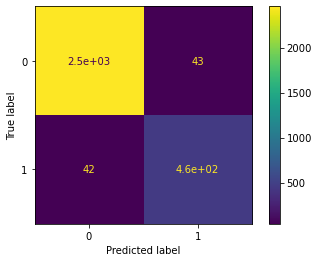

In [26]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = decision_tree.classes_)
disp.plot()

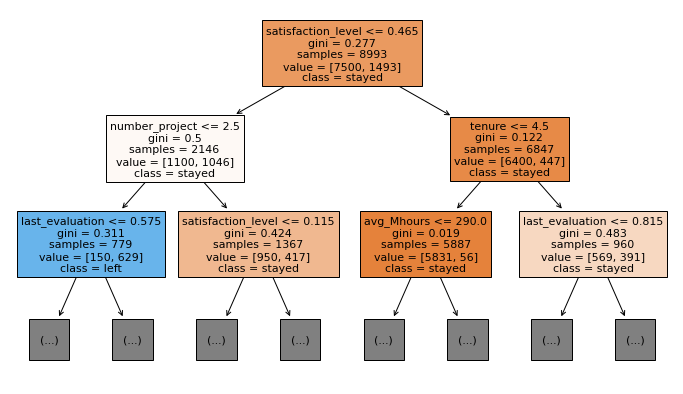

In [27]:
# Plot the tree:
plt.figure(figsize=(12,7))
plot_tree(decision_tree, max_depth = 2, fontsize = 11, feature_names = X.columns,
         class_names = {0: "stayed", 1: "left"}, filled = True);

plt.show()

In [28]:
# Feature importance

# pd.DataFrame({
#     "feature": X_train.columns,
#     "importance": decision_tree.feature_importances_
# }).sort_values("importance", ascending=False)

#### Conclusions: Baseline Decision Tree

In [29]:
################# Conclusion baseline decision tree: satisfaction is the ###############
# 1. Satisfaction is the most important factor differentiating those who leave the company vs those who stay. Dissatisfied tend to leave to a greater extent.
# 2. For thosw with low satisfaction, the next most important differentiating factor is the number of projects. Working on many projects simultaniously is related to greater dissatisfaction.
# 3. Among satisfied workers, tenure/time spent in a company plays an important role: satisfied who are less then 4.5 years in the company almost all stay. 
# 4. But IF people are in the company longer than 4.5 years --> pay attention to their last evaluation, it becomes relevant and it may signal the risk of leaving.

# I will now fine-tune this model, as well as do a XGBoost model and a logistic regression to confirm these results.

### Hyperparameters tuning: decision tree

In [30]:
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

In [31]:
%%time

clf = GridSearchCV(decision_tree,
                  tree_para, 
                  scoring=scoring,
                  cv=5,
                  refit="f1")

clf.fit(X_train, y_train)

CPU times: user 6.06 s, sys: 0 ns, total: 6.06 s
Wall time: 6.06 s


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50]

In [47]:
clf.best_estimator_
#clf.best_score_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [33]:
y_pred_tuned = clf.predict(X_test)

# Get the metrics and append them to the already existing results

tuned_results = {
    "model": "Tuned Decision Tree",
    "accuracy": accuracy_score(y_test, y_pred_tuned),
    "precision": precision_score(y_test, y_pred_tuned),
    "recall": recall_score(y_test, y_pred_tuned),
    "f1_score": f1_score(y_test, y_pred_tuned)
}

# Append to the existing results DataFrame
results = pd.concat([results, pd.DataFrame([tuned_results])], ignore_index=True)
results

,model,accuracy,precision,recall,f1_score
0,Decision Tree,0.971648,0.913828,0.915663,0.914744
1,Tuned Decision Tree,0.982655,0.964583,0.929719,0.946830


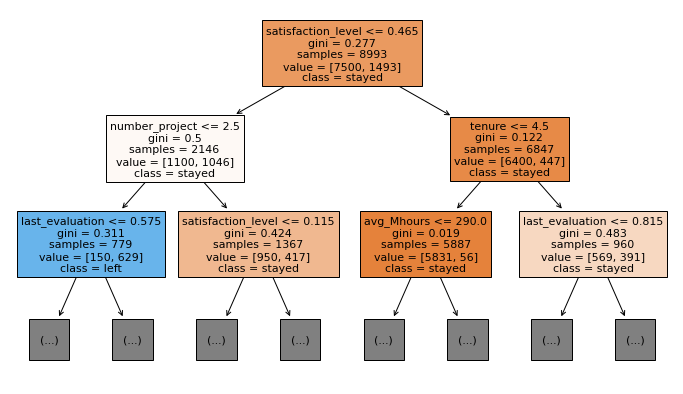

In [34]:
# Plot the tuned tree

plt.figure(figsize=(12,7))
plot_tree(clf.best_estimator_, max_depth = 2, fontsize = 11, feature_names = X.columns,
         class_names = ["stayed", "left"], filled = True);

plt.show()

In [51]:
# # feature importance extraction (based on gini, inherent to tree, see below for a better metric)
# tree2_importances = pd.DataFrame(
#     clf.best_estimator_.feature_importances_,   # remove redundant .best_estimator_
#     columns=['gini_importance'],
#     index=X.columns
# )

# tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# # Keep only features with importance > 0
# tree2_importances = tree2_importances[tree2_importances['gini_importance'] > 0]

# tree2_importances

# # Corrected plotting
# sns.barplot(
#     data=tree2_importances,
#     x="gini_importance",
#     y=tree2_importances.index,
#     orient='h'
# )

# plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
# plt.ylabel("Feature")
# plt.xlabel("Importance")
# plt.show()


#### Conclusion: Tuned Decission Tree

In [35]:
######################## Conclusion ########################
# My tuned tree didn't significantly improve the model, the "untuned" tree was already there,
# i.e., the baseline model captured the pattern already

# Just in case, I will now aslo run a XGB model and plot ranked featurs from the most to the least important one

### XGB Model

In [39]:
# So, a xgb model with the same vars

xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_params = {'max_depth': [4], 
             'min_child_weight': [1,2,3],
             'learning_rate': [0.1],
             'n_estimators': [75]
             }    

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=3, refit='f1')

In [40]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 11min 16s, sys: 765 ms, total: 11min 17s
Wall time: 5min 39s


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     predictor=None, random_state=0,
                   

In [41]:
# Make predictions with xgb

y_pred_xgb = xgb_cv.best_estimator_.predict(X_test)

In [42]:
# Get results and append it to the previous results

xgb_row = {
    "model": "XGBoost",
    "accuracy": accuracy_score(y_test, y_pred_xgb),
    "precision": precision_score(y_test, y_pred_xgb),
    "recall": recall_score(y_test, y_pred_xgb),
    "f1_score": f1_score(y_test, y_pred_xgb)
}
results = pd.concat([results, pd.DataFrame([xgb_row])], ignore_index=True)

In [43]:
results

,model,accuracy,precision,recall,f1_score
0,Decision Tree,0.971648,0.913828,0.915663,0.914744
1,Tuned Decision Tree,0.982655,0.964583,0.929719,0.946830
2,XGBoost,0.982989,0.968553,0.927711,0.947692


In [44]:
# How much model performance suffers, if you shuffle one feature? Compare XGB and decision tree feature importance

from sklearn.inspection import permutation_importance

def perm_importance(model, X, y, metric="f1", n=20):
    r = permutation_importance(model, X, y,
                               scoring=metric,
                               n_repeats=n,
                               random_state=42)
    return pd.Series(r.importances_mean, index=X.columns).sort_values(ascending=False)

# Compute for both models
imp_xgb  = perm_importance(xgb_cv.best_estimator_,  X_test, y_test)
imp_tree = perm_importance(clf.best_estimator_,     X_test, y_test)

print("\nXGBoost permutation importance:\n", imp_xgb.head(10))
print("\nDecision Tree permutation importance:\n", imp_tree.head(10))



XGBoost permutation importance:
 satisfaction_level    0.507272
number_project        0.242072
tenure                0.133476
last_evaluation       0.116621
avg_Mhours            0.114330
work_accident         0.002613
salary_low            0.001455
promotion_5y          0.000000
salary_medium         0.000000
salary_high          -0.000417
dtype: float64

Decision Tree permutation importance:
 satisfaction_level    0.557232
number_project        0.384597
last_evaluation       0.345760
avg_Mhours            0.276479
tenure                0.139015
work_accident         0.000000
promotion_5y          0.000000
salary_high           0.000000
salary_low           -0.000285
salary_medium        -0.000775
dtype: float64


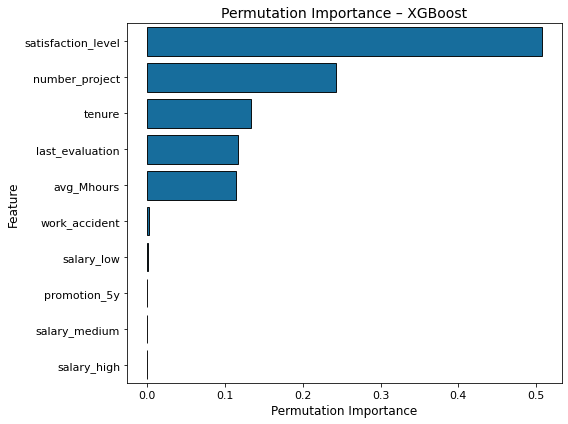

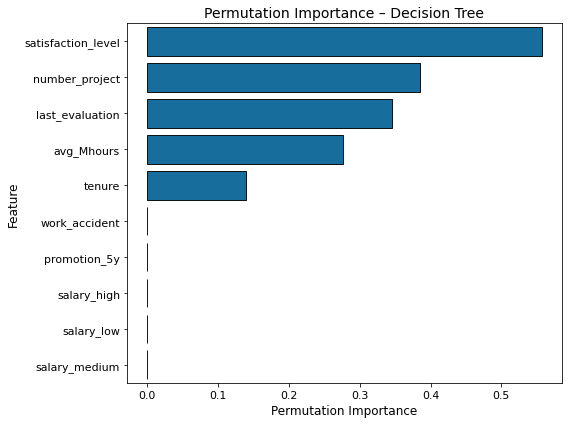

In [58]:
color = sns.color_palette("colorblind")[0]
def plot_perm_importance(imp_series, title):
    plt.figure(figsize=(8, 6))

    # Single color from colorblind palette
    single_color = sns.color_palette("colorblind")[0]

    sns.barplot(
        x=imp_series.values,
        y=imp_series.index,
        orient="h",
        color=single_color,
        linewidth=0.9,   # <-- thinner bar edges
        edgecolor="black"  # optional: clean outlines
    )

    # Slightly larger labels
    plt.title(title, fontsize=14)
    plt.xlabel("Permutation Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)

    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.tight_layout()
    plt.show()

# Plot them
plot_perm_importance(imp_xgb.head(15), "Permutation Importance – XGBoost")
plot_perm_importance(imp_tree.head(15), "Permutation Importance – Decision Tree")

#### Conclusions: XGBoost model

In [45]:
############ Conclusion: alright, so feature importance order nearly identical, this confirms everything ############
#### There is no need to go further than this

# Pace: Execute Stage

Double-click to enter your responses here.

### Summary of model results

I summarized and interpreted them all above, after each model.
Actionable recommendations are in a separate document called: executive summary.